In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m27odel import MultiDecoderCondVAE
from loss.l27oss_all import integrated_loss_fn


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/train_loader_all.pt',weights_only=False)
val_loader = torch.load('torch/val_loader_all.pt',weights_only=False)
test_loader = torch.load('torch/test_loader_all.pt',weights_only=False)


In [5]:
x_sample,x2_sample,x3_sample, c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
x2_dim = x2_sample.shape[1]
x3_dim = x3_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim,x2_dim,x3_dim,c_dim

(23, 6, 9, 45)

In [6]:
model = MultiDecoderCondVAE(x_dim,x2_dim,x3_dim, c_dim,z_dim=8,z2_dim = 8,z3_dim = 8).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_mse':[],'train_mse2':[],'train_mse3':[],'train_kl':[],'train_kl2':[],'train_kl3':[],
           'val_loss':[],'val_bce':[],'val_mse':[],'val_mse2':[],'val_mse3':[],'val_kl':[],'val_kl2':[],'val_kl3':[]}
epochs = 600

In [8]:
for epoch in range(1,epochs+1):
    model.train()
    t_loss,t_mse,t2_mse,t3_mse,t_bce,t_kl,t2_kl,t3_kl = 0,0,0,0,0,0,0,0
    for x,x2,x3,c in train_loader:
        x,x2,x3,c = x.to(device),x2.to(device),x3.to(device),c.to(device)
        optimizer.zero_grad()
        bce_logit ,binary_out, x_hat,x2_hat,x3_hat, z_mu,z_logvar,z2_mu,z2_logvar,z3_mu,z3_logvar = model(x,x2,x3,c)
        loss_dict = integrated_loss_fn(bce_logit,x_hat,x2_hat,x3_hat,x,x2,x3,z_mu,z_logvar,z2_mu,z2_logvar,z3_mu,z3_logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t2_mse +=loss_dict['mse2_loss'].item()
        t3_mse +=loss_dict['mse3_loss'].item()
        t_bce +=loss_dict['bce_loss'].item()
        t_kl +=loss_dict['kl_loss'].item()
        t2_kl +=loss_dict['kl2_loss'].item()
        t3_kl +=loss_dict['kl3_loss'].item()

    model.eval()
    v_loss,v_mse,v2_mse,v3_mse,v_bce,v_kl,v2_kl,v3_kl = 0,0,0,0,0,0,0,0
    with torch.no_grad():
        for v_x,v2_x,v3_x, v_c in val_loader:
            v_x,v2_x,v3_x,v_c = v_x.to(device),v2_x.to(device),v3_x.to(device), v_c.to(device)
            v_bce_logit,v_binary_out,v_x_hat,v2_x_hat,v3_x_hat, v_mu,v_logvar,v2_mu,v2_logvar,v3_mu,v3_logvar = model(v_x,v2_x,v3_x,v_c)
            loss_dict = integrated_loss_fn(v_bce_logit, v_x_hat, v2_x_hat,v3_x_hat,v_x,v2_x,v3_x, v_mu,v_logvar,v2_mu,v2_logvar,v3_mu,v3_logvar)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['mse_loss'].item()
            v2_mse += loss_dict['mse2_loss'].item()
            v3_mse += loss_dict['mse3_loss'].item()
            v_bce += loss_dict['bce_loss'].item()
            v_kl += loss_dict['kl_loss'].item()
            v2_kl += loss_dict['kl2_loss'].item()
            v3_kl += loss_dict['kl3_loss'].item()

    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_mse'].append(t_mse/len(train_loader))
    history['train_mse2'].append(t2_mse/len(train_loader))
    history['train_mse3'].append(t3_mse/len(train_loader))
    history['train_bce'].append(t_bce/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['train_kl2'].append(t2_kl/len(train_loader))
    history['train_kl3'].append(t3_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_mse'].append(v_mse/len(val_loader))
    history['val_mse2'].append(v2_mse/len(val_loader))
    history['val_mse3'].append(v3_mse/len(val_loader))
    history['val_bce'].append(v_bce/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))
    history['val_kl2'].append(v2_kl/len(val_loader))
    history['val_kl3'].append(v3_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break


Epoch [2/600]|Train:18.8238 |Val:19.1672
Epoch [20/600]|Train:11.5329 |Val:11.7115
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
Epoch [40/600]|Train:10.3020 |Val:10.3571
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
Epoch [60/600]|Train:9.7461 |Val:9.8464
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out o

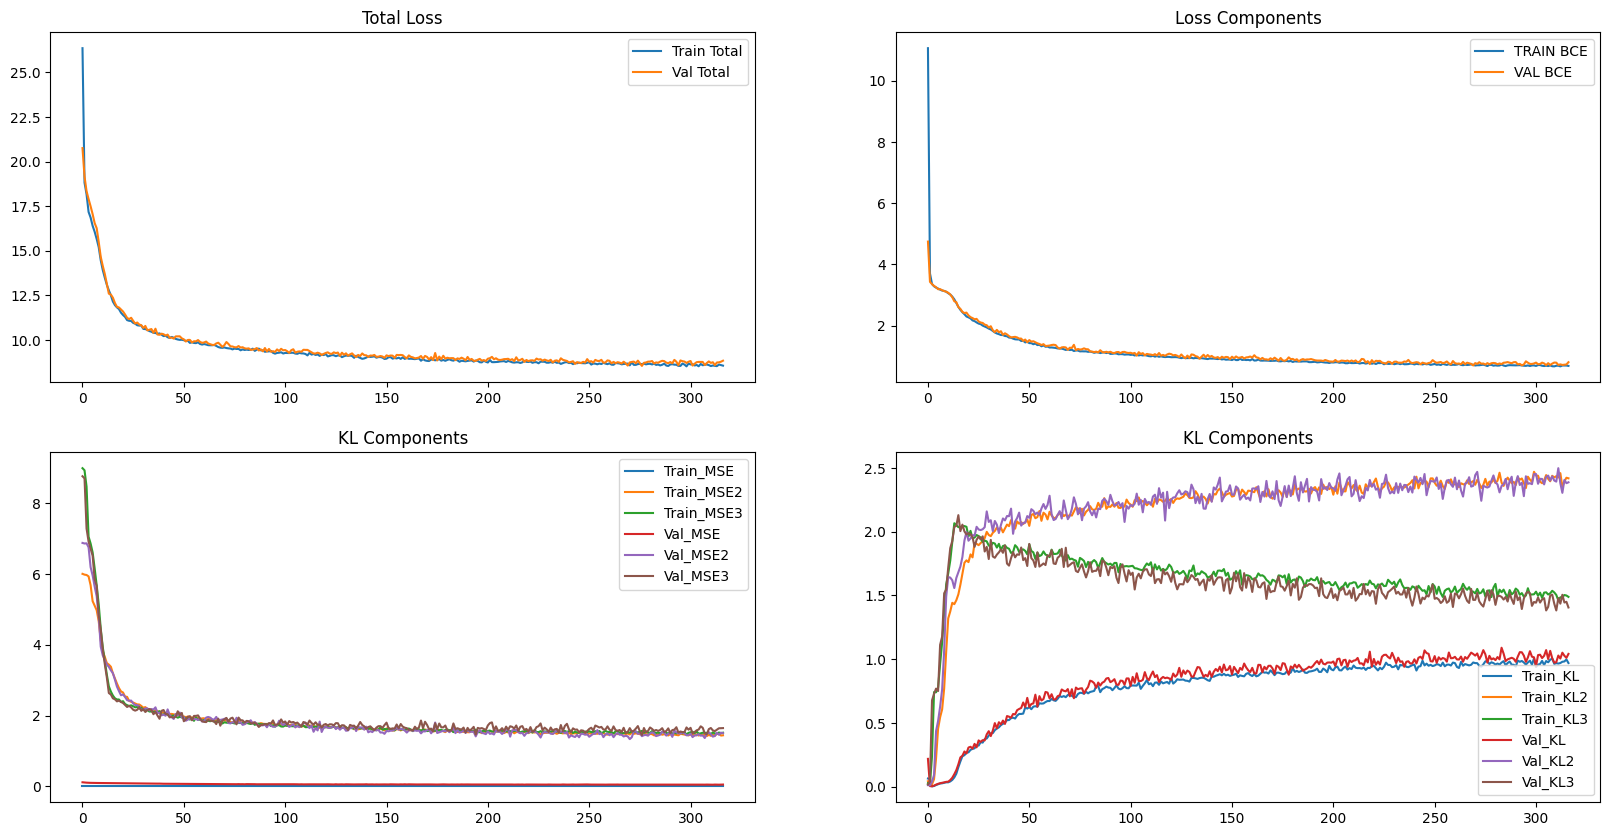

In [9]:
# 5. 결과 시각화
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history['train_mse'],label ='Train_MSE')
plt.plot(history['train_mse2'],label ='Train_MSE2')
plt.plot(history['train_mse3'],label ='Train_MSE3')
plt.plot(history['val_mse'], label = 'Val_MSE')
plt.plot(history['val_mse2'], label = 'Val_MSE2')
plt.plot(history['val_mse3'], label = 'Val_MSE3')
plt.title('KL Components')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['train_kl2'],label ='Train_KL2')
plt.plot(history['train_kl3'],label ='Train_KL3')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.plot(history['val_kl2'], label = 'Val_KL2')
plt.plot(history['val_kl3'], label = 'Val_KL3')
plt.title('KL Components')
plt.legend()
plt.show()

In [10]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
x_scaler = joblib.load('torch/a_27_x_scaler.pkl')
x2_scaler = joblib.load('torch/s_27_x2_scaler.pkl')
x3_scaler = joblib.load('torch/s_27_x3_scaler.pkl')
# c_scaler = joblib.load('torch/a_27_c_scaler.pkl')

c:\Users\User\anaconda3\envs\torch_gpu\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MaxAbsScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\torch_gpu\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
early_stopping.load_best_model(model)
model.eval()

x_true = []
x_pred = []
with torch.no_grad():
    for x_t, x2_t,x3_t, c_t in test_loader:
        x_t,x2_t,x3_t, c_t = x_t.to(device), x2_t.to(device), x3_t.to(device), c_t.to(device)

        bce_logit ,binary_out, x_hat,x2_hat,x3_hat, z_mu,z_logvar,z2_mu,z2_logvar,z3_mu,z3_logvar = model(x_t,x2_t,x3_t,c_t)
        prob_mask = torch.sigmoid(bce_logit)
        x_true.append(x_t.cpu().numpy())
        x_pred.append(x_hat.cpu().numpy())
all_x_true = np.vstack(x_true)
all_x_hat = np.vstack(x_pred)


Restored best model with loss: 8.551895


In [12]:
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_hat_raw = x_scaler.inverse_transform(all_x_hat)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = all_x_true.flatten()
x_pred = all_x_hat.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
history = {'RMSE':round(float(rmse),4),'R2':round(float(r2),4)}
history

{'RMSE': 0.0459, 'R2': 0.6336}

In [15]:
import json

# metrics 결과 저장
save_path = "all.json"

with open(save_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"지표가 {save_path}에 저장되었습니다.")

지표가 all.json에 저장되었습니다.


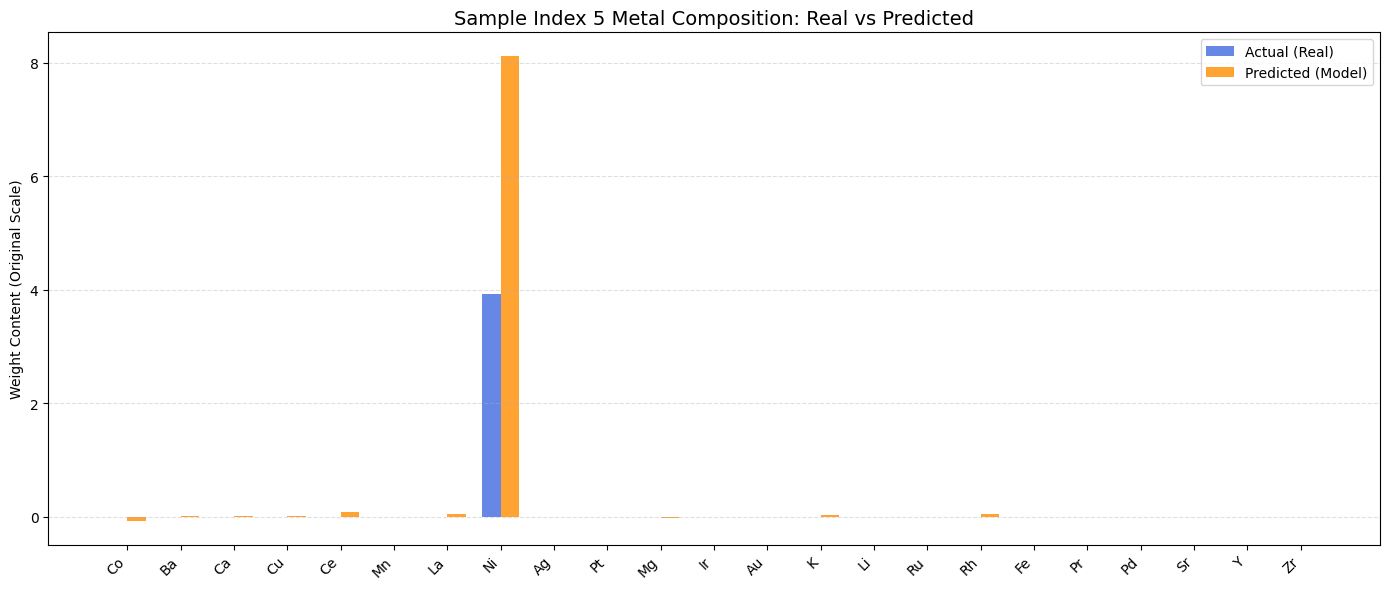

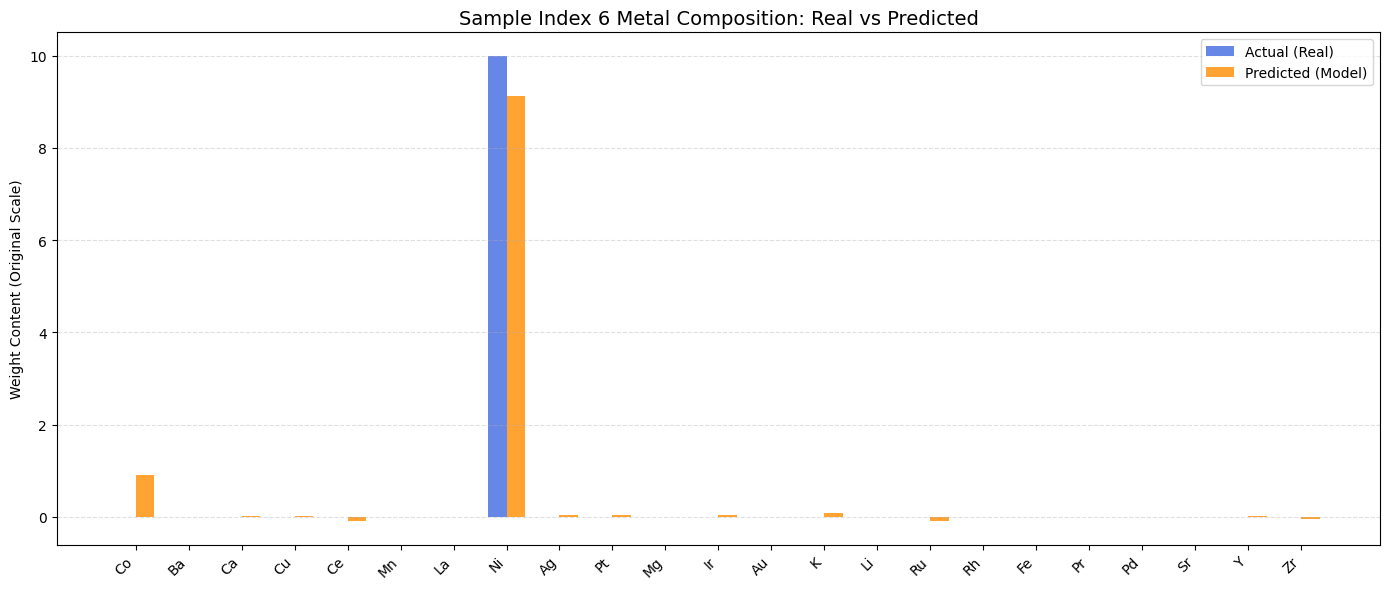

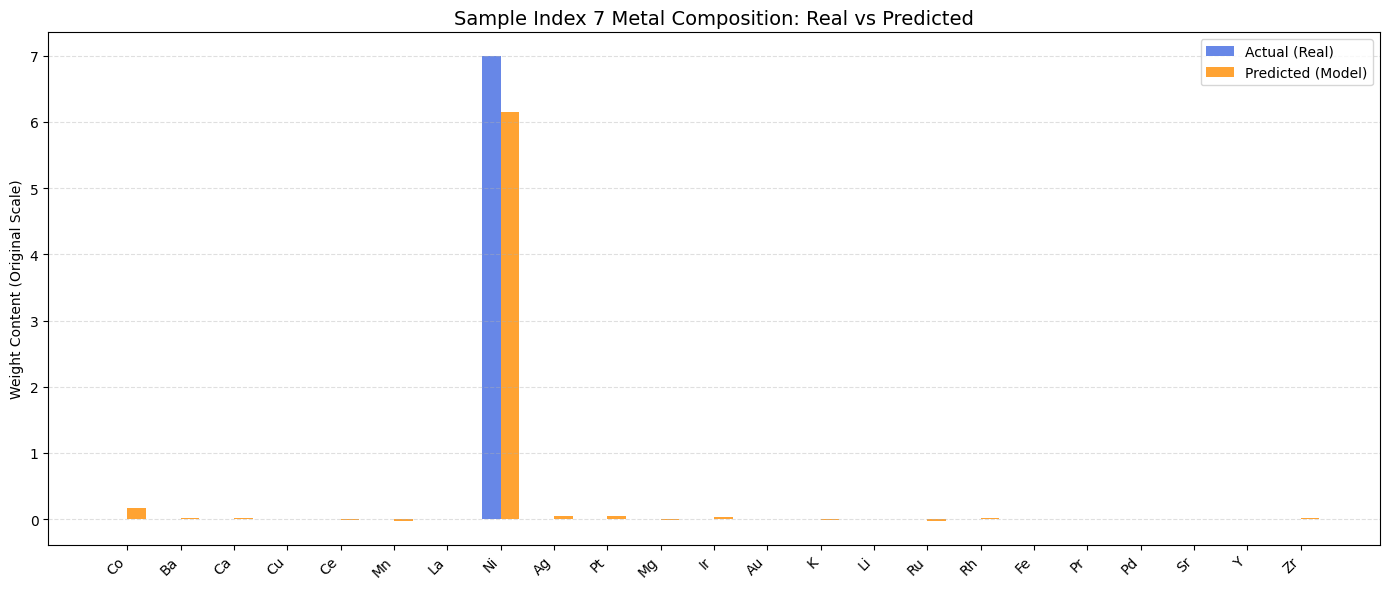

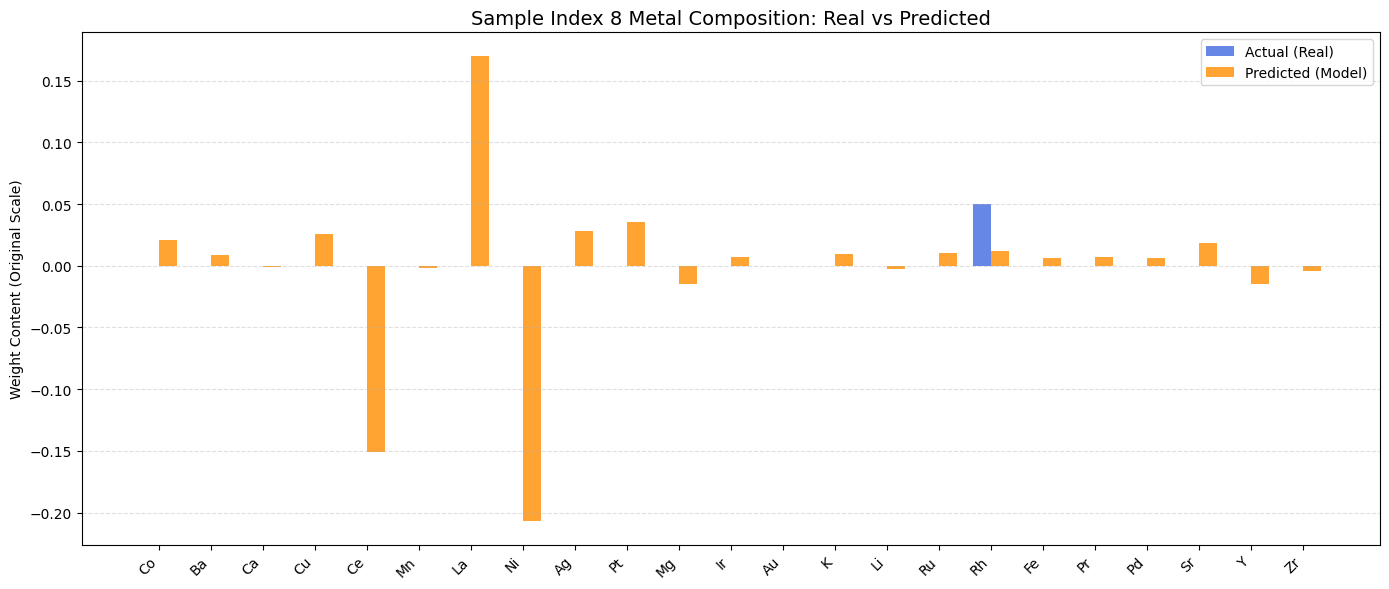

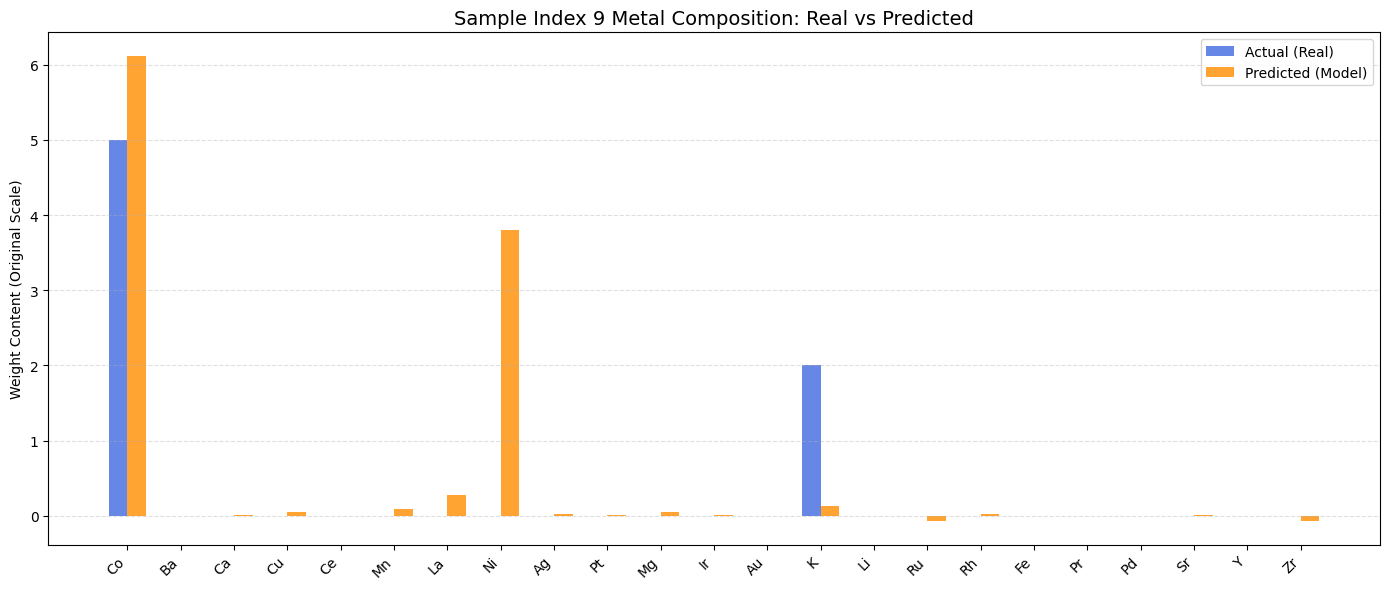

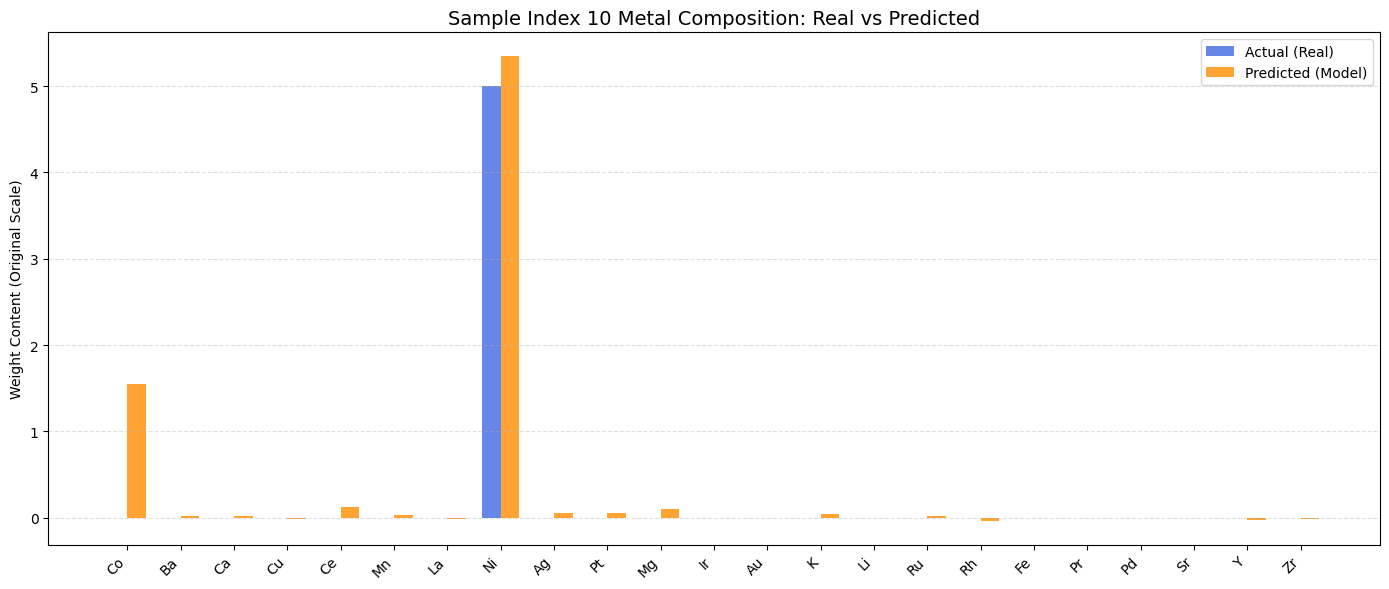

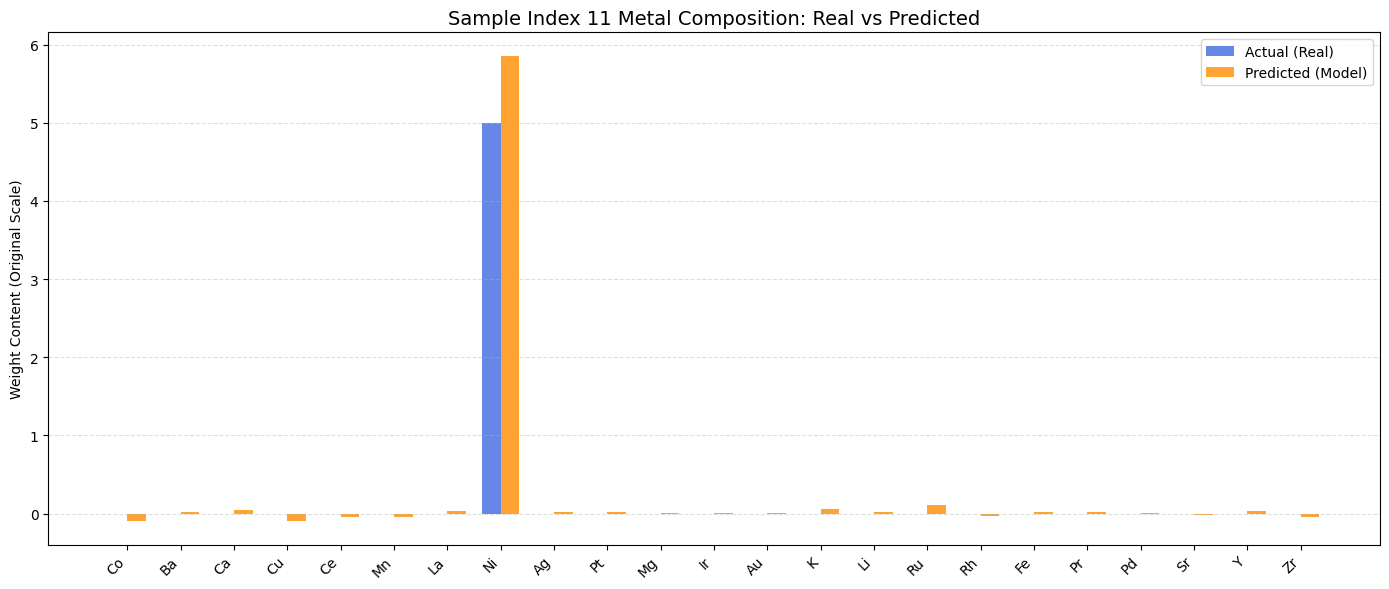

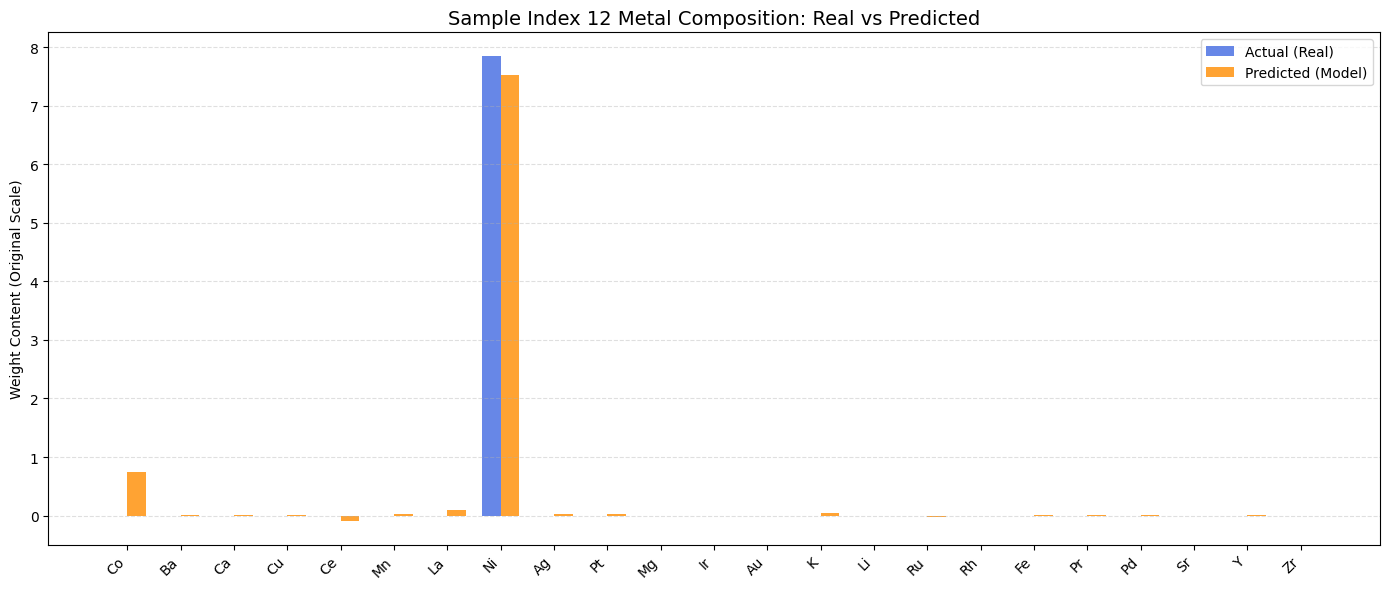

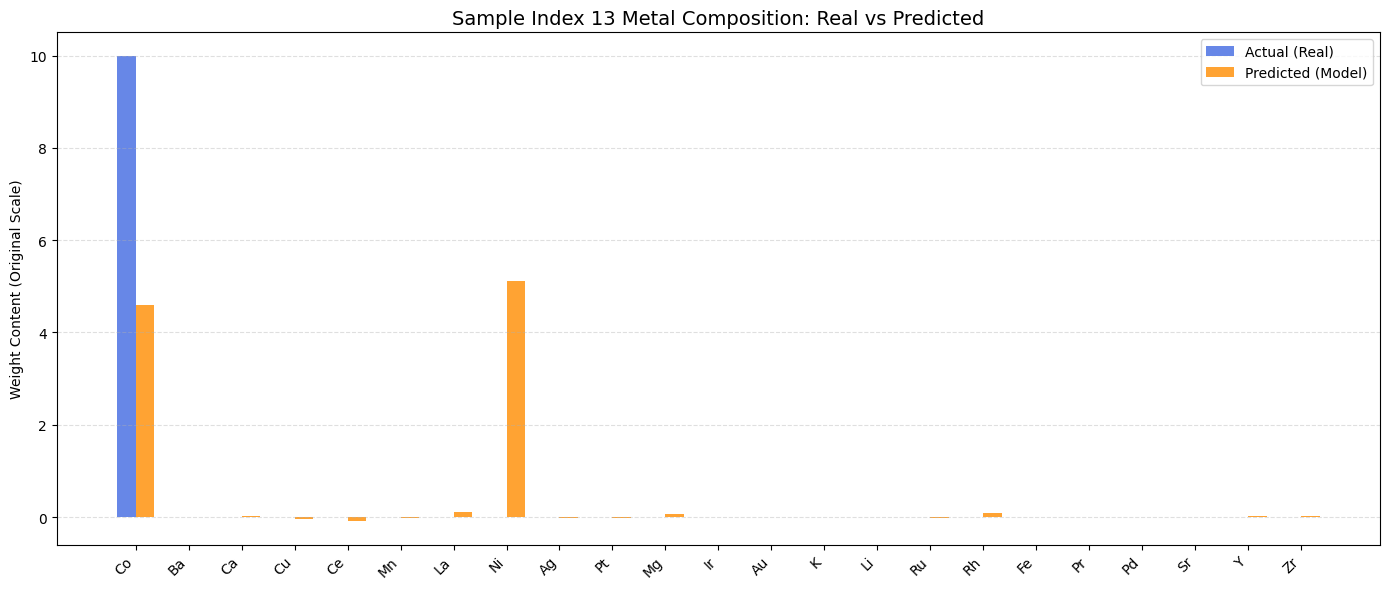

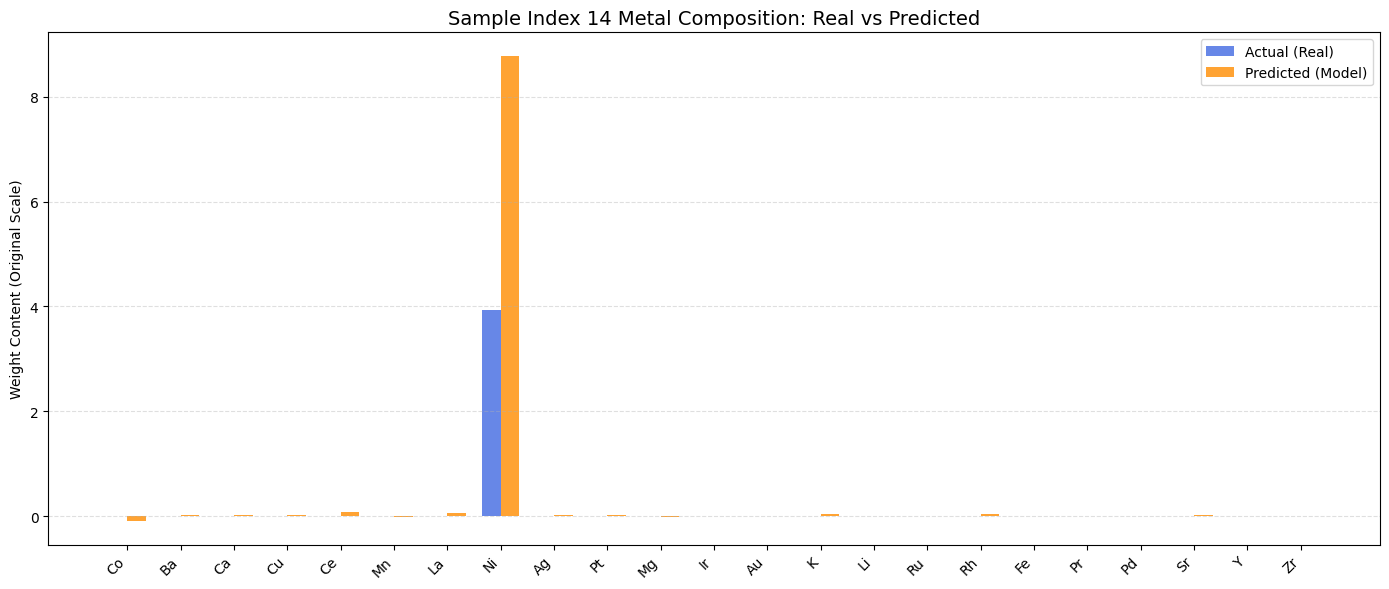

In [14]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2,x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()